In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
import matplotlib as mpl
from matplotlib import pyplot as plt, cm
from matplotlib import colors

plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#    'mathtext.fontset': 'custom',
#    'mathtext.rm': 'Bitstream Vera Sans',
#    'mathtext.it': 'Bitstream Vera Sans:italic',
#    'mathtext.bf': 'Bitstream Vera Sans:bold',   
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
})

from common import dalt
from common import hallmark as hm
from common import mockservation as mk
from common import viz
from common import io_ipole as io

In [2]:
def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)

def readsed(f, snapshot=None):

    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)
    
    return time, nu, avg, [k.decode("utf-8") for k in knd]

def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

def plsed(ax, name, **kwargs):
    time, nu, nuLnu, knd = readsed(name)
    
    pt = np.percentile(nuLnu[:,:,0], [1,50,99], axis=0)
    viz.step(ax, nu, pt[1], **kwargs)
    ax.fill_between(nu, pt[0], pt[2], step='mid', color=kwargs['color'], alpha=1/8, linewidth=0)

In [3]:
import ehtim as eh
import joblib as jl

obs = eh.obsdata.load_uvfits('data/SgrA_ER6_ver2021-04-15/3599/hops/hops_3599_SGRA_LO+HI_netcal_LMTcal_normalized_10s.uvfits')
obs = obs.avg_incoherent(60) # 1 min averaging

d    = obs.unpack(['u', 'v', 'vis'])
uvd0 = np.sqrt(d.u * d.u + d.v * d.v)
amp0 = abs(d.vis)

jl.dump(uvd0, 'uvd0.jl')
jl.dump(amp0, 'amp0.jl')

Welcome to eht-imaging! v 1.2.3 

Loading uvfits:  data/SgrA_ER6_ver2021-04-15/3599/hops/hops_3599_SGRA_LO+HI_netcal_LMTcal_normalized_10s.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Incoherently averaging data, putting phases to zero!


['amp0.jl']

In [4]:
import joblib as jl
uvd0 = jl.load('uvd0.jl')
amp0 = jl.load('amp0.jl')

In [5]:
def plva(name):

    mov = readimg(name)
    vis = mk.mockserve(mov, N=512)

    U, V = vis.uvd
    uu = np.linspace( 0,   U/2, num=vis.shape[-1])
    vv = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t  = vis.meta.time.value

    amp = RegularGridInterpolator((t, vv, uu[::-1]), abs     (vis[...,::-1]))
    uvd = np.linspace(0, 1.1e10, round(1e10/1e8)+1)
    
    va = []
    for t0 in tqdm(t):
        s_all = []
        for i in range(-90,90,45):
            phi = np.pi * i / 180
            uu  = uvd * np.cos(phi)
            vv  = uvd * np.sin(phi)

            mask = (uu <= 0)
            p = np.array([np.repeat(t0, np.sum( mask)),  vv[ mask],  uu[ mask]]).T
            m = np.array([np.repeat(t0, np.sum(~mask)), -vv[~mask], -uu[~mask]]).T
    
            s = np.zeros(len(uvd))
            s[ mask] = amp(p)
            s[~mask] = amp(m)
        
            s_all.append(s/s[0])
        va.append(s_all)
            
    return uvd, np.array(va)

In [6]:
uvd, vaF = plva('cache/Illinois_thermal_w5/Ma+0.5_i90/gt_Rh40_230GHz.h5')
uvd, vaP = plva('cache/Illinois_thermal_w5/Ma+0.5_i30/gt_Rh40_230GHz.h5')

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 295.53it/s]


In [7]:
from common.io_ipole import load_img

imgF = load_img('model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s05991_Rh40_i90.h5')
imgP = load_img('model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s05991_Rh40_i30.h5')

In [8]:
from astropy import constants as c

nu = 227070703125.0 * u.Hz # input image may have this information

scale = c.c**2 / (2 * c.k_B * nu**2) * u.rad**2

print(np.max((imgF * scale).to(u.K)))
print(np.max((imgP * scale).to(u.K)))

vmax = 15e9

105827846861.29831 K
56110280759.30932 K


Bbox(x0=0.5451111111111111, y0=0.5118357487922705, x1=0.9688055555555556, y1=0.9723731884057971)


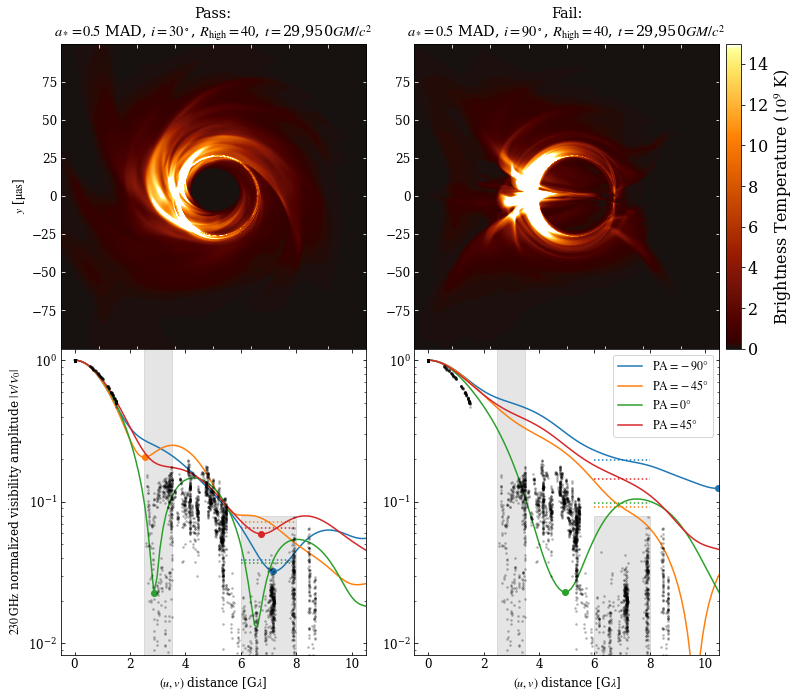

In [13]:
frame = -9

nmin = 2.5e9
nmax = 3.5e9

bmin = 6e9
bmax = 8e9

fig, axes = plt.subplots(2, 2, figsize=(10,9.2))
fig.tight_layout()
plt.subplots_adjust(hspace=0)

axes[0,0].set_title('Pass:\n$a_*=\!0.5$ MAD, $i=30^\circ$, $R_\mathrm{high}=40$, $t=$29,950$GM/c^2$')
axes[0,0].tick_params(
    axis='both',
    direction='in',
    top=True,
    right=True,
    color='w',
)
viz.show(imgP, f=lambda img: (img * scale).to(u.K), ax=axes[0,0], cmap='afmhot_10us', vmin=0, vmax=vmax)
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels([])

axes[0,1].set_title('Fail:\n$a_*\!=0.5$ MAD, $i=90^\circ$, $R_\mathrm{high}=40$, $t=$29,950$GM/c^2$')
axes[0,1].tick_params(
    axis='both',
    direction='in',
    top=True,
    right=True,
    color='w',
)
viz.show(imgF, f=lambda img: (img * scale).to(u.K), ax=axes[0,1], cmap='afmhot_10us', vmin=0, vmax=vmax)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_xticklabels([])

axes[1,0].axvspan(nmin/1e9, nmax/1e9, color='k', alpha=1/10, edgecolor=None)
axes[1,0].fill_between([bmin/1e9, bmax/1e9], 0.04/0.5, color='k', alpha=1/10)
lc = [argrelextrema(vaP[frame,i,:], np.less)[0] for i in range(4)]
for i, PA in enumerate(range(-90,90,45)):
    p = axes[1,0].plot(uvd/1e9, vaP[frame,i,:], label=f'$\mathrm{{PA}}={PA}\degree$')
    if len(lc[i]) > 0:
        axes[1,0].scatter(uvd[lc[i][0]]/1e9, vaP[frame,i,lc[i][0]], color=p[0].get_color())
    la = np.median(vaP[frame,i,(bmin <= uvd) & (uvd <= bmax)])
    axes[1,0].plot([bmin/1e9, bmax/1e9], [la, la], ':', color=p[0].get_color())
axes[1,0].scatter(uvd0/1e9, amp0, s=3, color='black', alpha=0.2, zorder=2)
axes[1,0].set_yscale('log')
axes[1,0].set_xlim(-0.5, 10.5)
axes[1,0].set_ylim(0.1/12, 0.1*12)
axes[1,0].set_xlabel('$(u, v)$ distance [G$\lambda$]')
axes[1,0].set_ylabel('$230\,\mathrm{GHz}$ normalized visibility amplitude $|V/V_0|$')
axes[1,0].tick_params(
    which='both',
    axis='both',
    direction='in',
    top=True,
    right=True)

axes[1,1].axvspan(nmin/1e9, nmax/1e9, color='k', alpha=1/10, edgecolor=None)
axes[1,1].fill_between([bmin/1e9, bmax/1e9], 0.04/0.5, color='k', alpha=1/10)
lc = [argrelextrema(vaF[frame,i,:], np.less)[0] for i in range(4)]
for i, PA in enumerate(range(-90,90,45)):
    p = axes[1,1].plot(uvd/1e9, vaF[frame,i,:], label=f'$\mathrm{{PA}}={PA}\degree$')
    if len(lc[i]) > 0:
        axes[1,1].scatter(uvd[lc[i][0]]/1e9, vaF[frame,i,lc[i][0]], color=p[0].get_color())
    la = np.median(vaF[frame,i,(bmin <= uvd) & (uvd <= bmax)])
    axes[1,1].plot([bmin/1e9, bmax/1e9], [la, la], ':', color=p[0].get_color())
axes[1,1].scatter(uvd0/1e9, amp0, s=3, color='black', alpha=0.2, zorder=2)
axes[1,1].set_yscale('log')
axes[1,1].set_xlim(-0.5, 10.5)
axes[1,1].set_ylim(0.1/12, 0.1*12)
axes[1,1].set_xlabel('$(u, v)$ distance [G$\lambda$]')
axes[1,1].tick_params(
    which='both',
    axis='both',
    direction='in',
    top=True,
    right=True)
axes[1,1].legend()

#axes[0,2].axis('off')
#axes[1,2].axis('off')

pos = axes[0,1].get_position()
print(pos)

cbaxes = fig.add_axes([pos.x1+0.01, pos.y0, 0.02, pos.y1-pos.y0])
cbar = fig.colorbar(cm.ScalarMappable(mpl.colors.Normalize(0,15), cmap='afmhot_10us'), ticks=np.arange(0, 15, 2), orientation="vertical", cax=cbaxes)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label="Brightness Temperature ($10^9$ K)", size=16)

fig.savefig('output/passfail_va.pdf', bbox_inches='tight')